In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
SOURCE_DATA_DIR = 'csv_self_data' # Дериктория с исходными данными (csv файлами, содержащими один столбец с заголовком "vibration")
OUTPUT_DATASET_DIR = 'output_data_self_norm_16k_1024' # Дериктория для результатов преобразования (изображения соответствующего размера и разрешения)

SAMPLING_RATE = 9000 # Частота дискретизации      
WINDOW_SIZE = 16384 # Размер фрейма для дробления исходных данных   
STEP = 8192 # Шаг фрейма              

NPERSEG = 1024 # Размер фрейма для создания спектрограммы            
IMAGE_HEIGHT = 513 # Высота сохраняемого изображения спектрограммы
IMAGE_WIDTH = 15361 # Ширина сохраняемого изображения спектрограммы
NOVERLAP = NPERSEG - 1 #коэф наложения фрейма   
DPI = 100 # Разрешение изображения         

In [3]:
def copy_files(file_list, subset_name):
    for file_path in file_list:
        label = os.path.basename(os.path.dirname(file_path))
        dest_dir = os.path.join(OUTPUT_DATASET_DIR, subset_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(file_path, dest_dir)
    print(f"Скопировано {len(file_list)} файлов в '{subset_name}'")

In [5]:
def create_and_save_spectrogram_normalized(signal_data, fs, save_path):
    """
    Создает спектрограмму из фрагмента сигнала, нормализует ее в диапазон [0, 1]
    и сохраняет как изображение.
    """

    frequencies, times, Zxx = signal.stft(
        signal_data, 
        fs=fs, 
        nperseg=NPERSEG, 
        noverlap=NOVERLAP, 
        boundary=None,
    )
    # Получаем модуль (амплитуду) спектрограммы
    Zxx_abs = np.abs(Zxx)
    # Нормализация данных от 0 до 1
    min_val = np.min(Zxx_abs)
    max_val = np.max(Zxx_abs)
    if max_val > min_val:
        Zxx_normalized = (Zxx_abs - min_val) / (max_val - min_val)
    else:
        # Избегаем деления на ноль, если все значения одинаковы
        Zxx_normalized = np.zeros_like(Zxx_abs)
    print(Zxx.shape)
    height, width = IMAGE_HEIGHT, IMAGE_WIDTH # Для проверки Zxx.shape[0], Zxx.shape[1]
    dpi = DPI
    fig_size = (width / dpi, height / dpi)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Используем нормализованные данные для отображения
    ax.imshow(Zxx_normalized, cmap='gray', origin='lower', aspect='auto')
    ax.axis('off')
    plt.savefig(save_path, dpi=dpi)
    plt.close()

Начинаем создание датасета...

Обработка класса: 'normal'
  Читаем файл: 10Hz_accelerometer.csv
(513, 15361)
(513, 15361)
(513, 15361)
(513, 15361)


KeyboardInterrupt: 

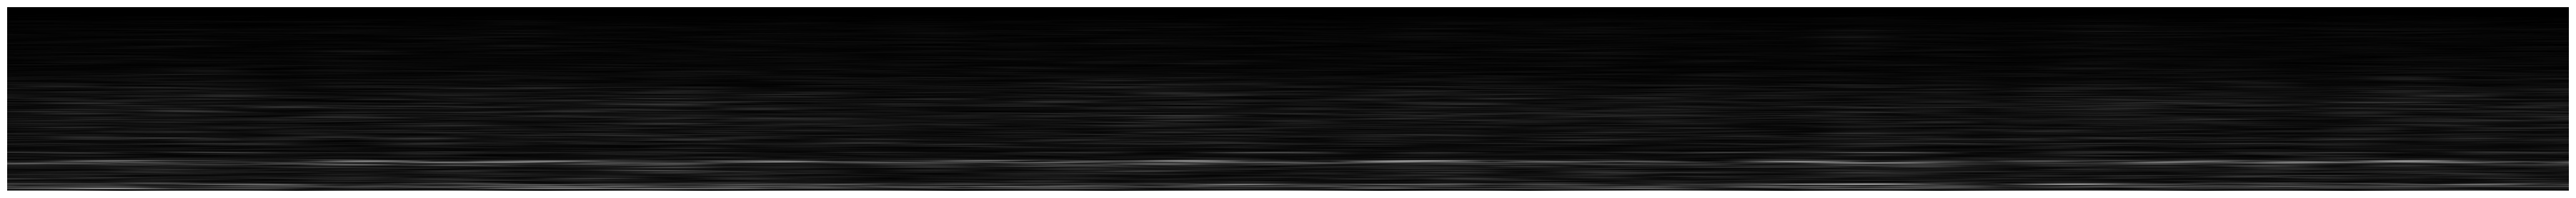

In [6]:
def generate_dataset():
    """
    Главная функция для обработки всех файлов и создания датасета.
    """
    print("Начинаем создание датасета...")

    if os.path.exists(OUTPUT_DATASET_DIR):
        shutil.rmtree(OUTPUT_DATASET_DIR)
        print(f"Очищена старая директория: {OUTPUT_DATASET_DIR}")

    all_file_chunks = []
    temp_image_dir = os.path.join(OUTPUT_DATASET_DIR, 'temp_images')

    for label in ['normal', 'defect']:
        source_dir = os.path.join(SOURCE_DATA_DIR, label)
        print(f"\nОбработка класса: '{label}'")
        for filename in os.listdir(source_dir):
            if filename.endswith('.csv'):
                file_path = os.path.join(source_dir, filename)
                print(f"  Читаем файл: {filename}")
                try:
                    df = pd.read_csv(file_path)
                    signal_data = df['vibration'].values
                    chunk_count = 0
                    
                    for i in range(0, len(signal_data) - WINDOW_SIZE + 1, STEP):
                        chunk = signal_data[i : i + WINDOW_SIZE]
                        base_filename = os.path.splitext(filename)[0]
                        image_filename = f"{label}_{base_filename}_chunk_{chunk_count:04d}.png"
                        class_temp_dir = os.path.join(temp_image_dir, label)
                        os.makedirs(class_temp_dir, exist_ok=True)
                        save_path = os.path.join(class_temp_dir, image_filename)
                        create_and_save_spectrogram_normalized(chunk, SAMPLING_RATE, save_path)
                        all_file_chunks.append((save_path, label))
                        chunk_count += 1
                    print(f"    -> Создано {chunk_count} изображений.")
                except Exception as e:
                    print(f"    ОШИБКА при обработке файла {filename}: {e}")
    print(f"\nВсего создано изображений: {len(all_file_chunks)}")
    paths, labels = zip(*all_file_chunks)
    train_paths, val_paths, _, _ = train_test_split(paths, labels, test_size=0.2, random_state=42, stratify=labels)

    copy_files(train_paths, 'train')
    copy_files(val_paths, 'validation')
    shutil.rmtree(temp_image_dir)

if __name__ == '__main__':
    generate_dataset()